<b> A complete guide: https://scikit-learn.org/stable/modules/clustering.html </b>

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [36]:
df = pd.read_csv("seismic-bumps.csv")

In [37]:
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,hazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180,48,-72,-72,a,0,0,0,0,0,0,0,0,0,0,0
1,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,0,0,0,2000,2000,0
2,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0,0,0,0
3,a,a,N,28820,171,-23,40,a,1,0,1,0,0,0,0,0,3000,3000,0
4,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0,0,0,0


,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,hazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180,48,-72,-72,a,0,0,0,0,0,0,0,0,0,0,0
1,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,0,0,0,2000,2000,0
2,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0,0,0,0
3,a,a,N,28820,171,-23,40,a,1,0,1,0,0,0,0,0,3000,3000,0
4,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2579,b,a,W,81410,785,432,151,b,0,0,0,0,0,0,0,0,0,0,0
2580,b,a,W,42110,555,213,118,a,0,0,0,0,0,0,0,0,0,0,0
2581,b,a,W,26960,540,101,112,a,0,0,0,0,0,0,0,0,0,0,0
2582,a,a,W,16130,322,2,2,a,0,0,0,0,0,0,0,0,0,0,0


In [57]:
# dropping the row containing the outlier

df.drop(index=[1691], inplace=True)

In [55]:
# Applying log transform

df['log_t_genergy'] = np.log(df['genergy'])
df['log_t_gpuls'] = np.log(df['gpuls'])

In [70]:
# Initializing the variables with values to be clustered

V = df[['genergy', 'gpuls']].to_numpy()
X = df[['log_t_genergy', 'log_t_gpuls']].to_numpy()
Y = df[['gdenergy', 'gdpuls']].to_numpy()
Z = df[['energy', 'maxenergy']].to_numpy()

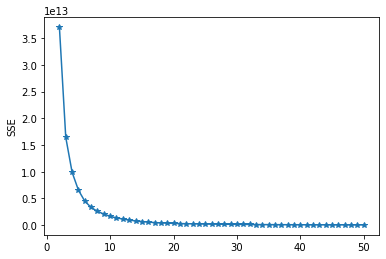

In [71]:
# calculating the Sum of Squared Error (SSE) for K in range(2, 52)
sse_list = []

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(V)
    sse_list.append( kmeans.inertia_ )
    
plt.plot(range(2, len(sse_list)+2), sse_list, marker='*')
plt.ylabel('SSE')
plt.show()

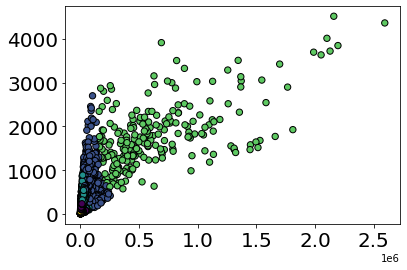

In [76]:
# Applying k-mean on "genergy - gpuls" for k = 5

kmeans = KMeans( n_clusters=5, n_init=20, max_iter=100 )
kmeans.fit(X)

plt.scatter( V[:,0], V[:,1], s=40, edgecolor='black', c= kmeans.labels_ )

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

In [74]:
# calculating the Sum of Squared Error (SSE) for K in range(2, 52)
sse_list = []

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X)
    sse_list.append( kmeans.inertia_ )

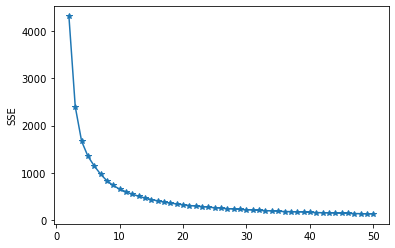

In [75]:
plt.plot(range(2, len(sse_list)+2), sse_list, marker='*')
plt.ylabel('SSE')
plt.show()

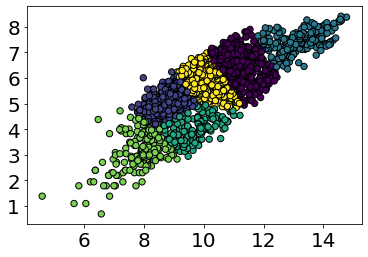

In [79]:
# Applying k-mean on "log_t_genergy - log_t_gpuls" for k = 6

kmeans = KMeans( n_clusters=6, n_init=20, max_iter=100 )
kmeans.fit(X)

plt.scatter( X[:,0], X[:,1], s=40, edgecolor='black', c= kmeans.labels_ )

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

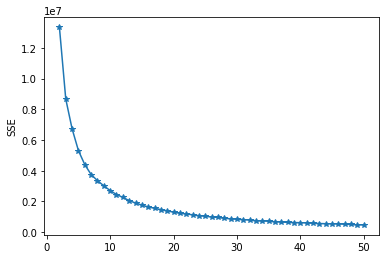

In [184]:
# calculating the Sum of Squared Error (SSE) for K in range(2, 52)

sse_list = []

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(Y)
    sse_list.append( kmeans.inertia_ )
    
plt.plot(range(2, len(sse_list)+2), sse_list, marker='*')
plt.ylabel('SSE')
plt.show()

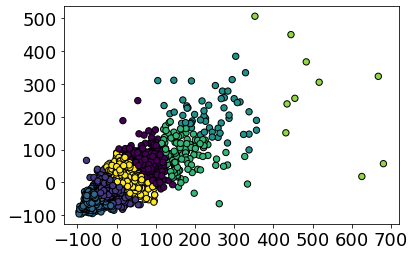

In [63]:
# Applying k-mean on "gdenergy - gdpuls" for k = 7

kmeans = KMeans( n_clusters=7, n_init=10, max_iter=100 )
kmeans.fit(Y)

plt.scatter( Y[:,0], Y[:,1], s=40, edgecolor='black', c= kmeans.labels_ )

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

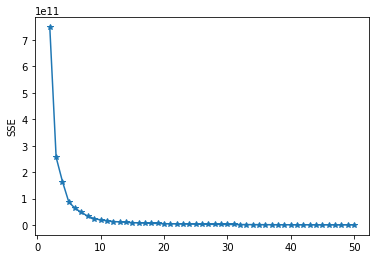

In [60]:
# calculating the Sum of Squared Error (SSE) for K in range(2, 52)

sse_list = []

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(Z)
    sse_list.append( kmeans.inertia_ )
    
plt.plot(range(2, len(sse_list)+2), sse_list, marker='*')
plt.ylabel('SSE')
plt.show()

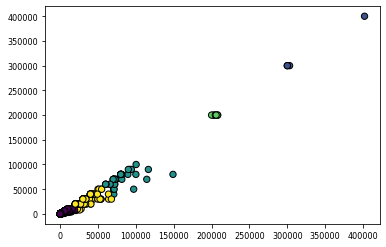

In [187]:
# Applying k-mean on "energy - maxenergy" for k = 5

kmeans = KMeans( n_clusters=5, n_init=10, max_iter=100 )
kmeans.fit(Z)

plt.scatter( Z[:,0], Z[:,1], s=40, edgecolor='black', c= kmeans.labels_ )

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

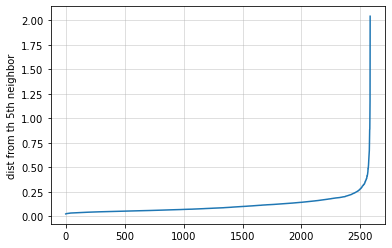

In [188]:
dist = pdist(X, 'euclidean')
dist = squareform(dist)

k=6
kth_distances = []
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])
    
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from th 5th neighbor')

plt.grid(alpha=0.5)
plt.show()

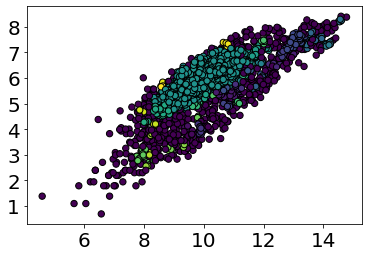

In [78]:
# Applying k-mean on "log_t_genergy - log_t_gpuls" for eps = 0.10 and min_sample = 5

dbscan = DBSCAN( eps=0.10, min_samples=5)
dbscan.fit(X)

plt.scatter( X[:,0], X[:,1], s=40, edgecolor='black', c= dbscan.labels_ )

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

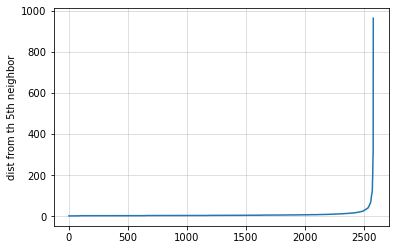

In [190]:
# Determing eps and 

dist = pdist(Y, 'euclidean')
dist = squareform(dist)

k=6
kth_distances = []
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])
    
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from th 5th neighbor')

plt.grid(alpha=0.5)
plt.show()

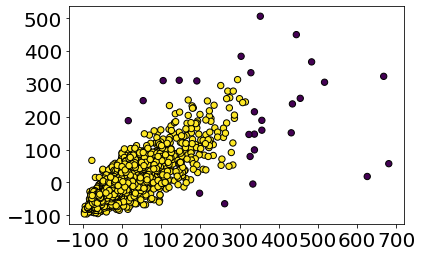

In [64]:
# Applying k-mean on "gdenergy - gdpuls" for eps = 40 and min_sample = 5

dbscan = DBSCAN( eps=40, min_samples=5)
dbscan.fit(Y)

plt.scatter( Y[:,0], Y[:,1], s=40, edgecolor='black', c= dbscan.labels_ )

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

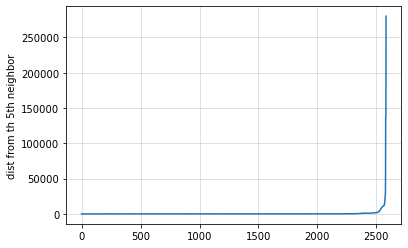

In [192]:
dist = pdist(Z, 'euclidean')
dist = squareform(dist)

k=6
kth_distances = []
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])
    
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from th 5th neighbor')

plt.grid(alpha=0.5)
plt.show()

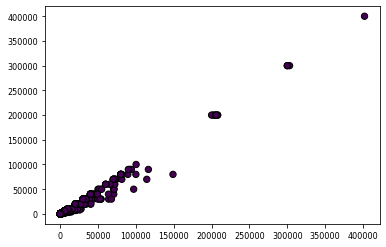

In [201]:
# Applying k-mean on "energy - maxenergy" for eps = 8000 and min_sample = 5

dbscan = DBSCAN( eps=8000, min_samples=5)
dbscan.fit(Y)

plt.scatter( Z[:,0], Z[:,1], s=40, edgecolor='black', c= dbscan.labels_ )

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()